In [ ]:
# Setup and Imports

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from train import train
from model_test import test
from atk import ATTACK_CONFIGS
import torch.optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.optim as optim
from model import *
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
# Model Training Configurations

In [3]:
# Training configurations
configs = [
    {'name': 'ReLU-Clean', 'use_spike': False, 'atk': 'none'},
    {'name': 'ReLU-GN', 'use_spike': False, 'atk': 'gn'},
    {'name': 'ReLU-PGD', 'use_spike': False, 'atk': 'pgd'},
    {'name': 'Spike-Clean', 'use_spike': True, 'model_type': 'stateless_resnet', 'atk': 'none'},
    {'name': 'Spike-GN', 'use_spike': True, 'model_type': 'stateless_resnet', 'atk': 'gn'},
    {'name': 'Spike-PGD', 'use_spike': True, 'model_type': 'stateless_resnet', 'atk': 'pgd'}
]

In [ ]:
# Training Phase

In [4]:
# Training phase
training_results = {}
for config in configs:
    print(f"\nTraining {config['name']}...")
    results = train(
        use_spike=config['use_spike'],
        atk=config['atk'],
        epochs=20,
        batch_size=64,
        lr=0.01,
        model_type=config['model_type'] if 'model_type' in config else 'standard'
    )
    training_results[config['name']] = results


Training ReLU-Clean...
Using standard ResNet34 model
Training non-spiking ResNet34 model on cuda


/home/joel/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1, Batch 0, Loss: 2.4172
Epoch 1, Batch 20, Loss: 2.2445
Epoch 1, Batch 40, Loss: 1.3052
Epoch 1, Batch 60, Loss: 1.2980
Epoch 1, Batch 80, Loss: 0.4348
Epoch [1/20], Loss: 1.5527, Train Acc: 53.78%, Test Acc: 68.02%
Epoch 2, Batch 0, Loss: 0.5203
Epoch 2, Batch 20, Loss: 0.4442
Epoch 2, Batch 40, Loss: 0.3756
Epoch 2, Batch 60, Loss: 0.2984
Epoch 2, Batch 80, Loss: 0.1338
Epoch [2/20], Loss: 0.3945, Train Acc: 88.93%, Test Acc: 90.00%
Epoch 3, Batch 0, Loss: 0.0643
Epoch 3, Batch 20, Loss: 0.2453
Epoch 3, Batch 40, Loss: 0.1211
Epoch 3, Batch 60, Loss: 0.2743
Epoch 3, Batch 80, Loss: 0.2725
Epoch [3/20], Loss: 0.2321, Train Acc: 93.21%, Test Acc: 91.04%
Epoch 4, Batch 0, Loss: 0.0976
Epoch 4, Batch 20, Loss: 0.0927
Epoch 4, Batch 40, Loss: 0.2464
Epoch 4, Batch 60, Loss: 0.1353
Epoch 4, Batch 80, Loss: 0.1120
Epoch [4/20], Loss: 0.1625, Train Acc: 95.09%, Test Acc: 95.10%
Epoch 5, Batch 0, Loss: 0.1352
Epoch 5, Batch 20, Loss: 0.0297
Epoch 5, Batch 40, Loss: 0.0132
Epoch 5, Batc

In [ ]:
# Training Results Visualization

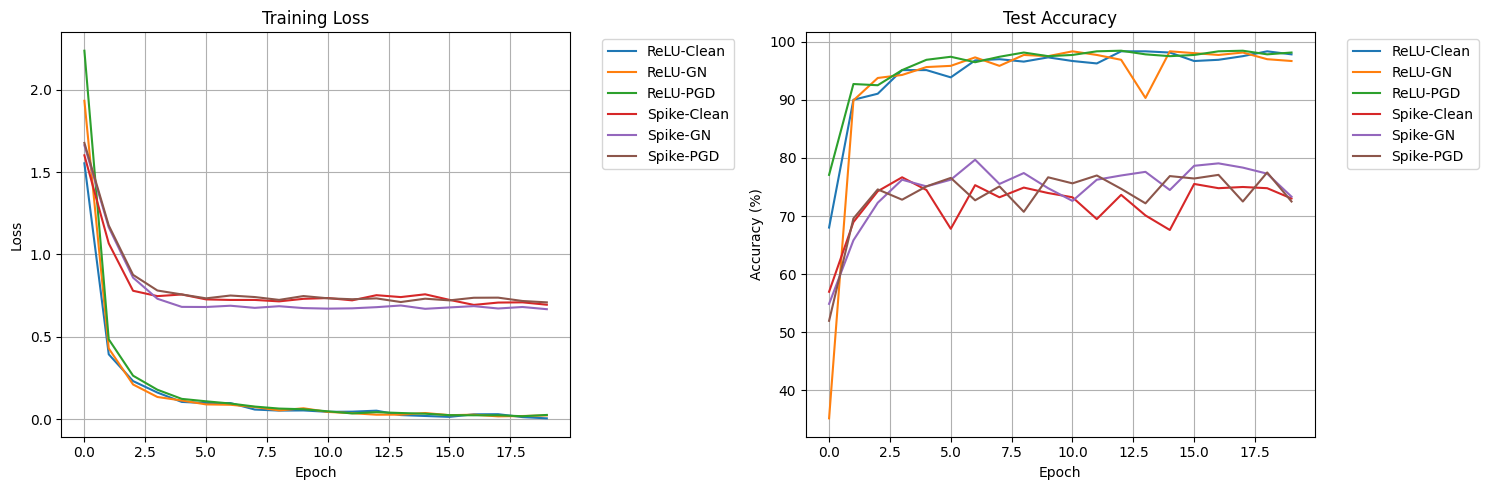

In [5]:
# Plot training curves
plt.figure(figsize=(15, 5))

# Training Loss
plt.subplot(1, 2, 1)
for config in configs:
    plt.plot(training_results[config['name']]['train_losses'], 
             label=config['name'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Test Accuracy
plt.subplot(1, 2, 2)
for config in configs:
    plt.plot(training_results[config['name']]['test_accuracies'], 
             label=config['name'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

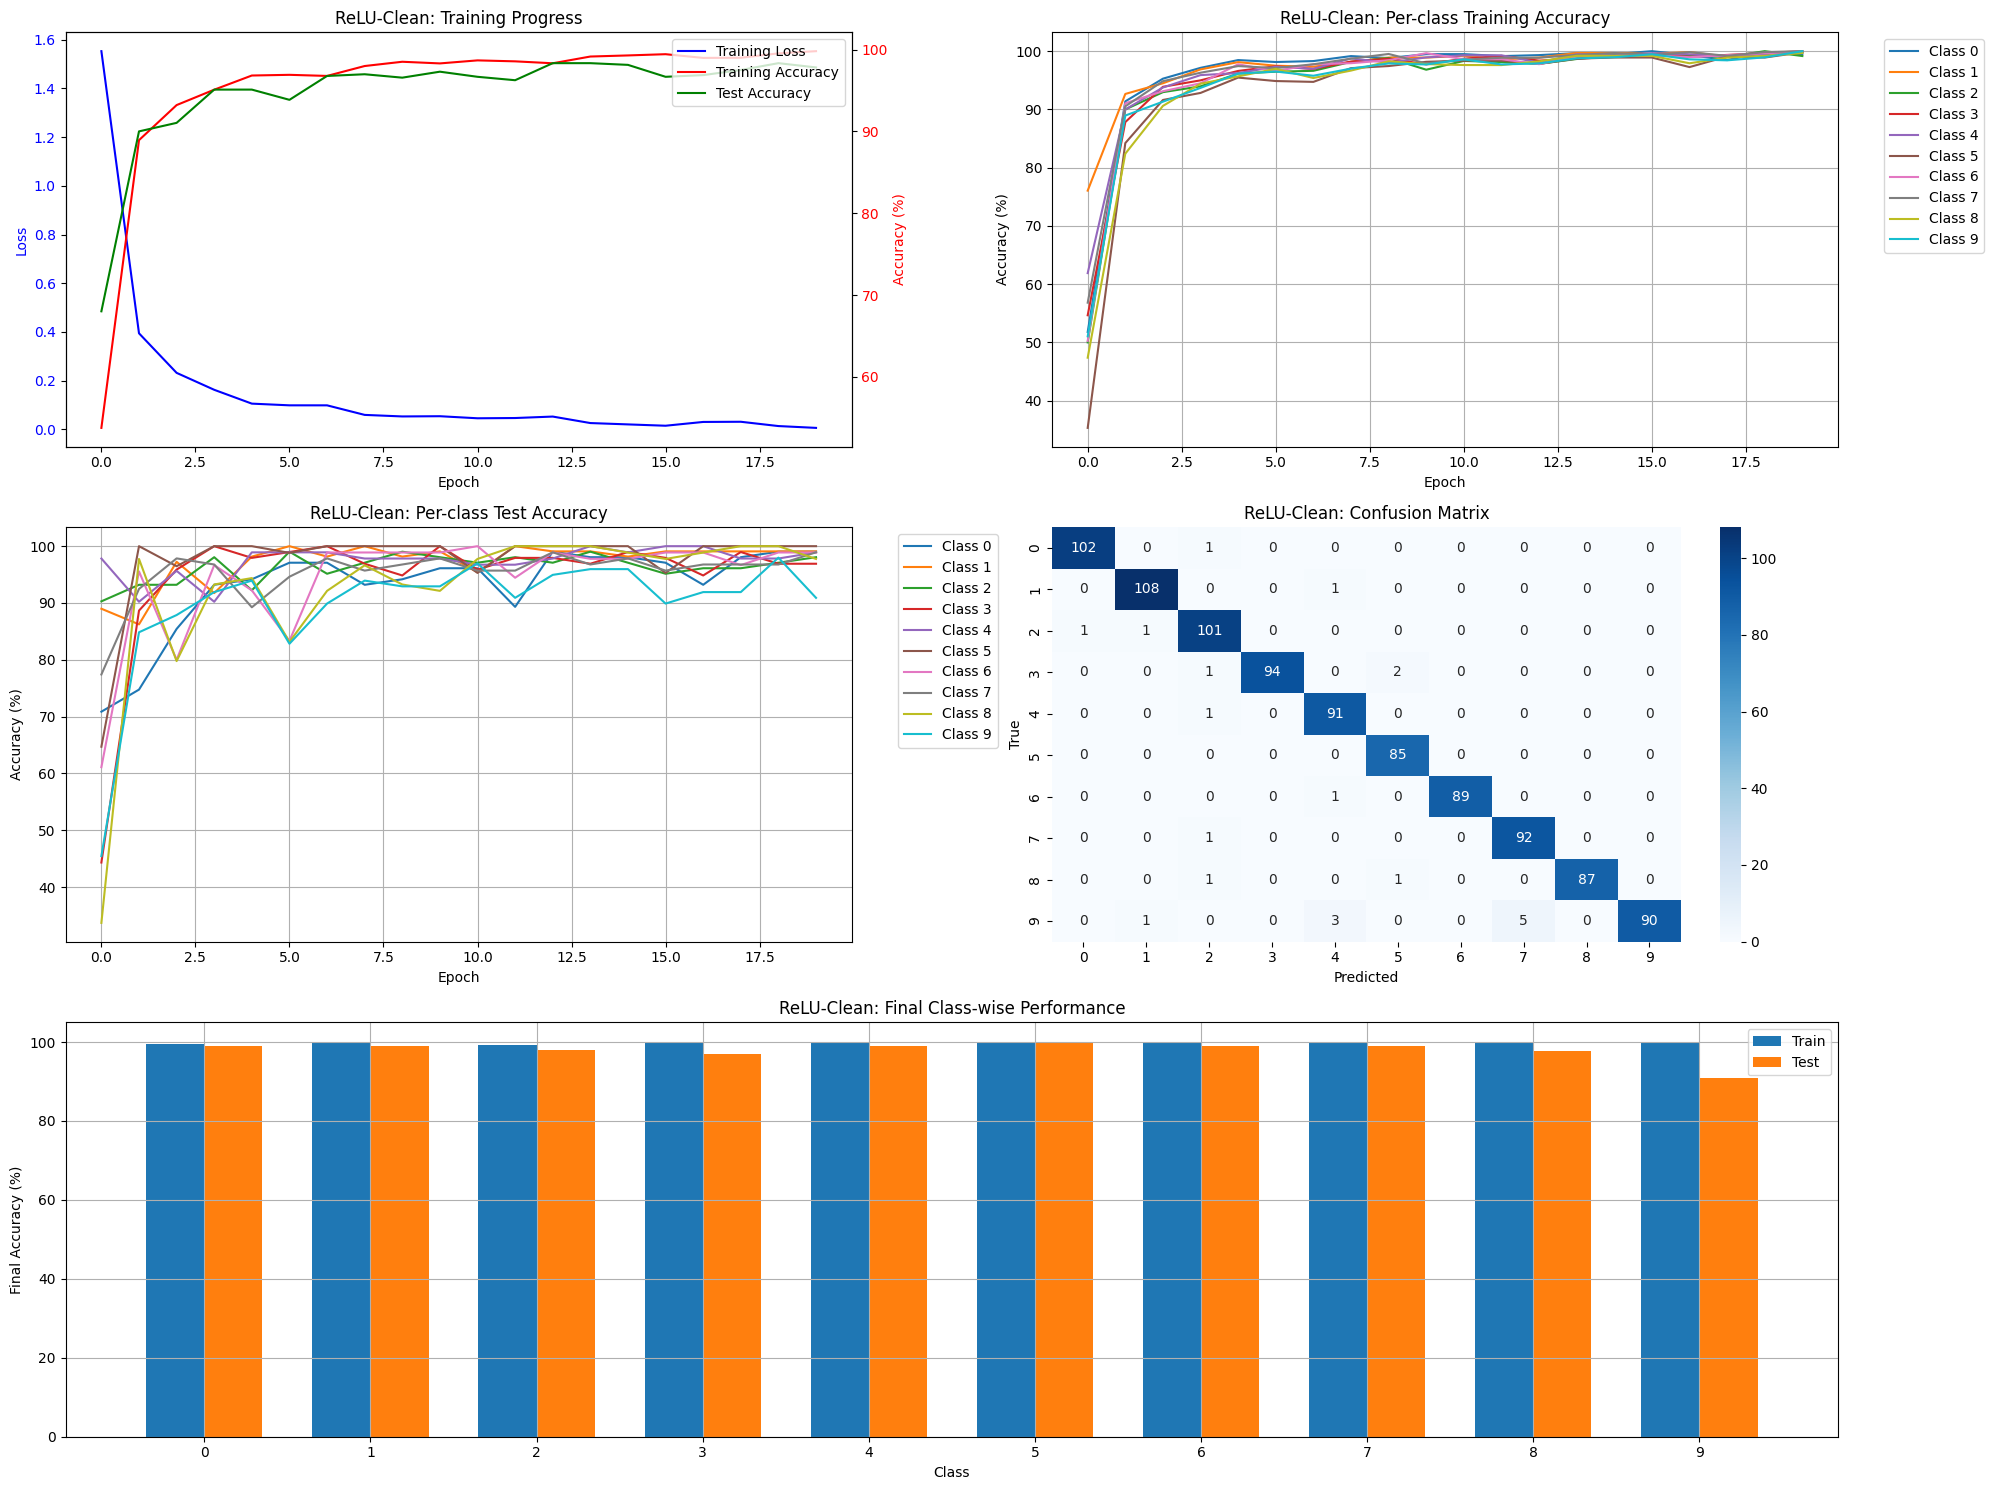

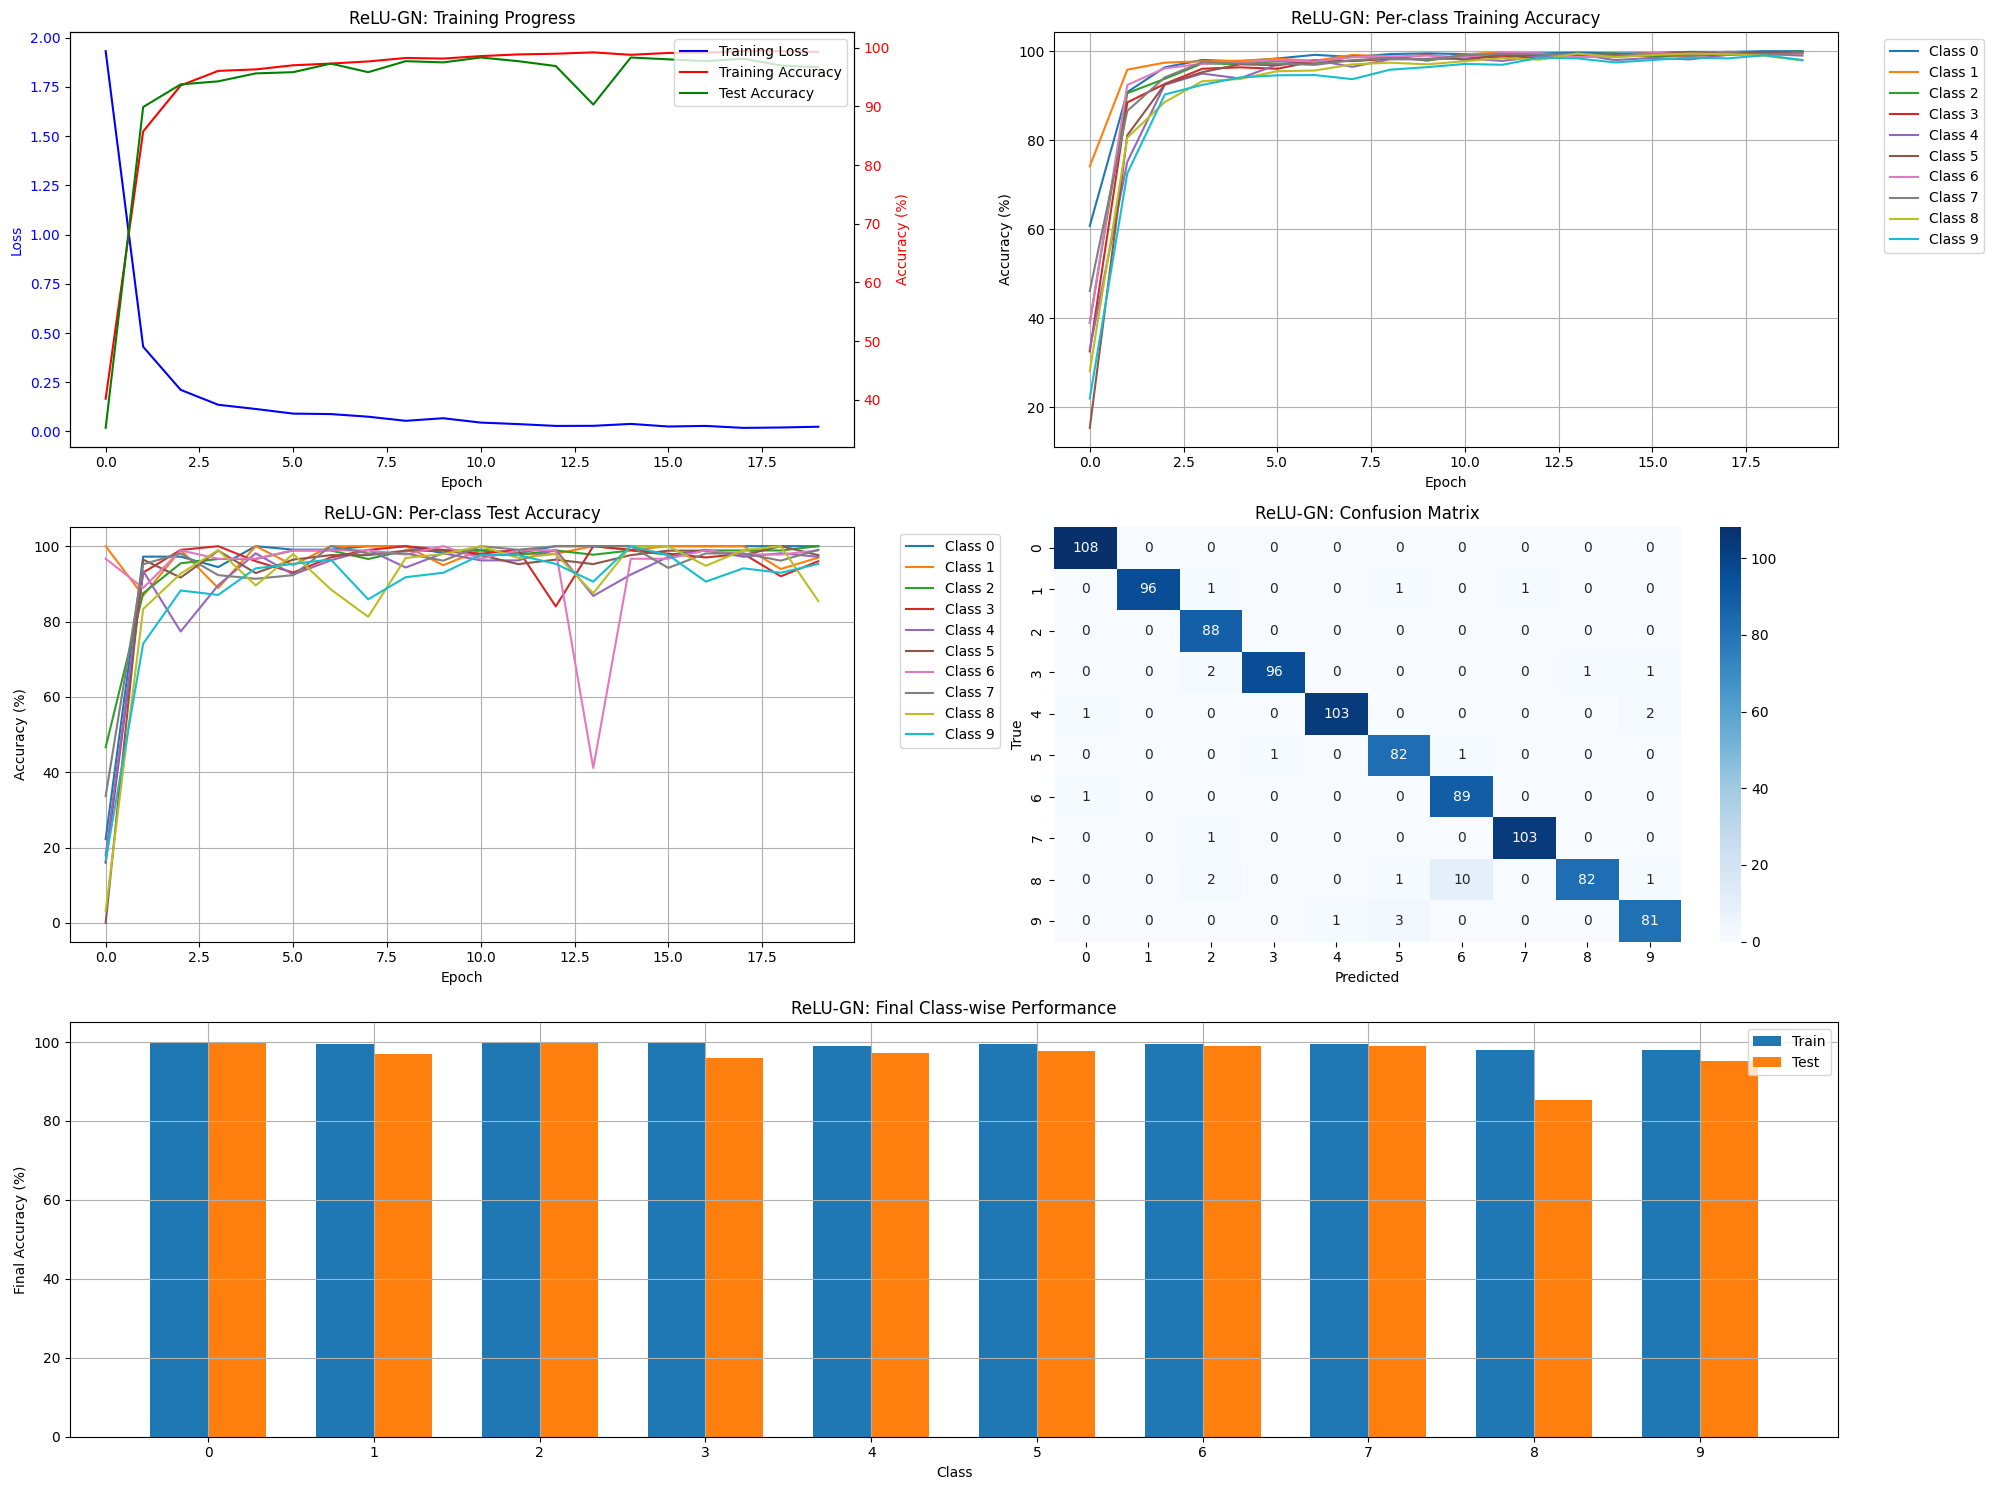

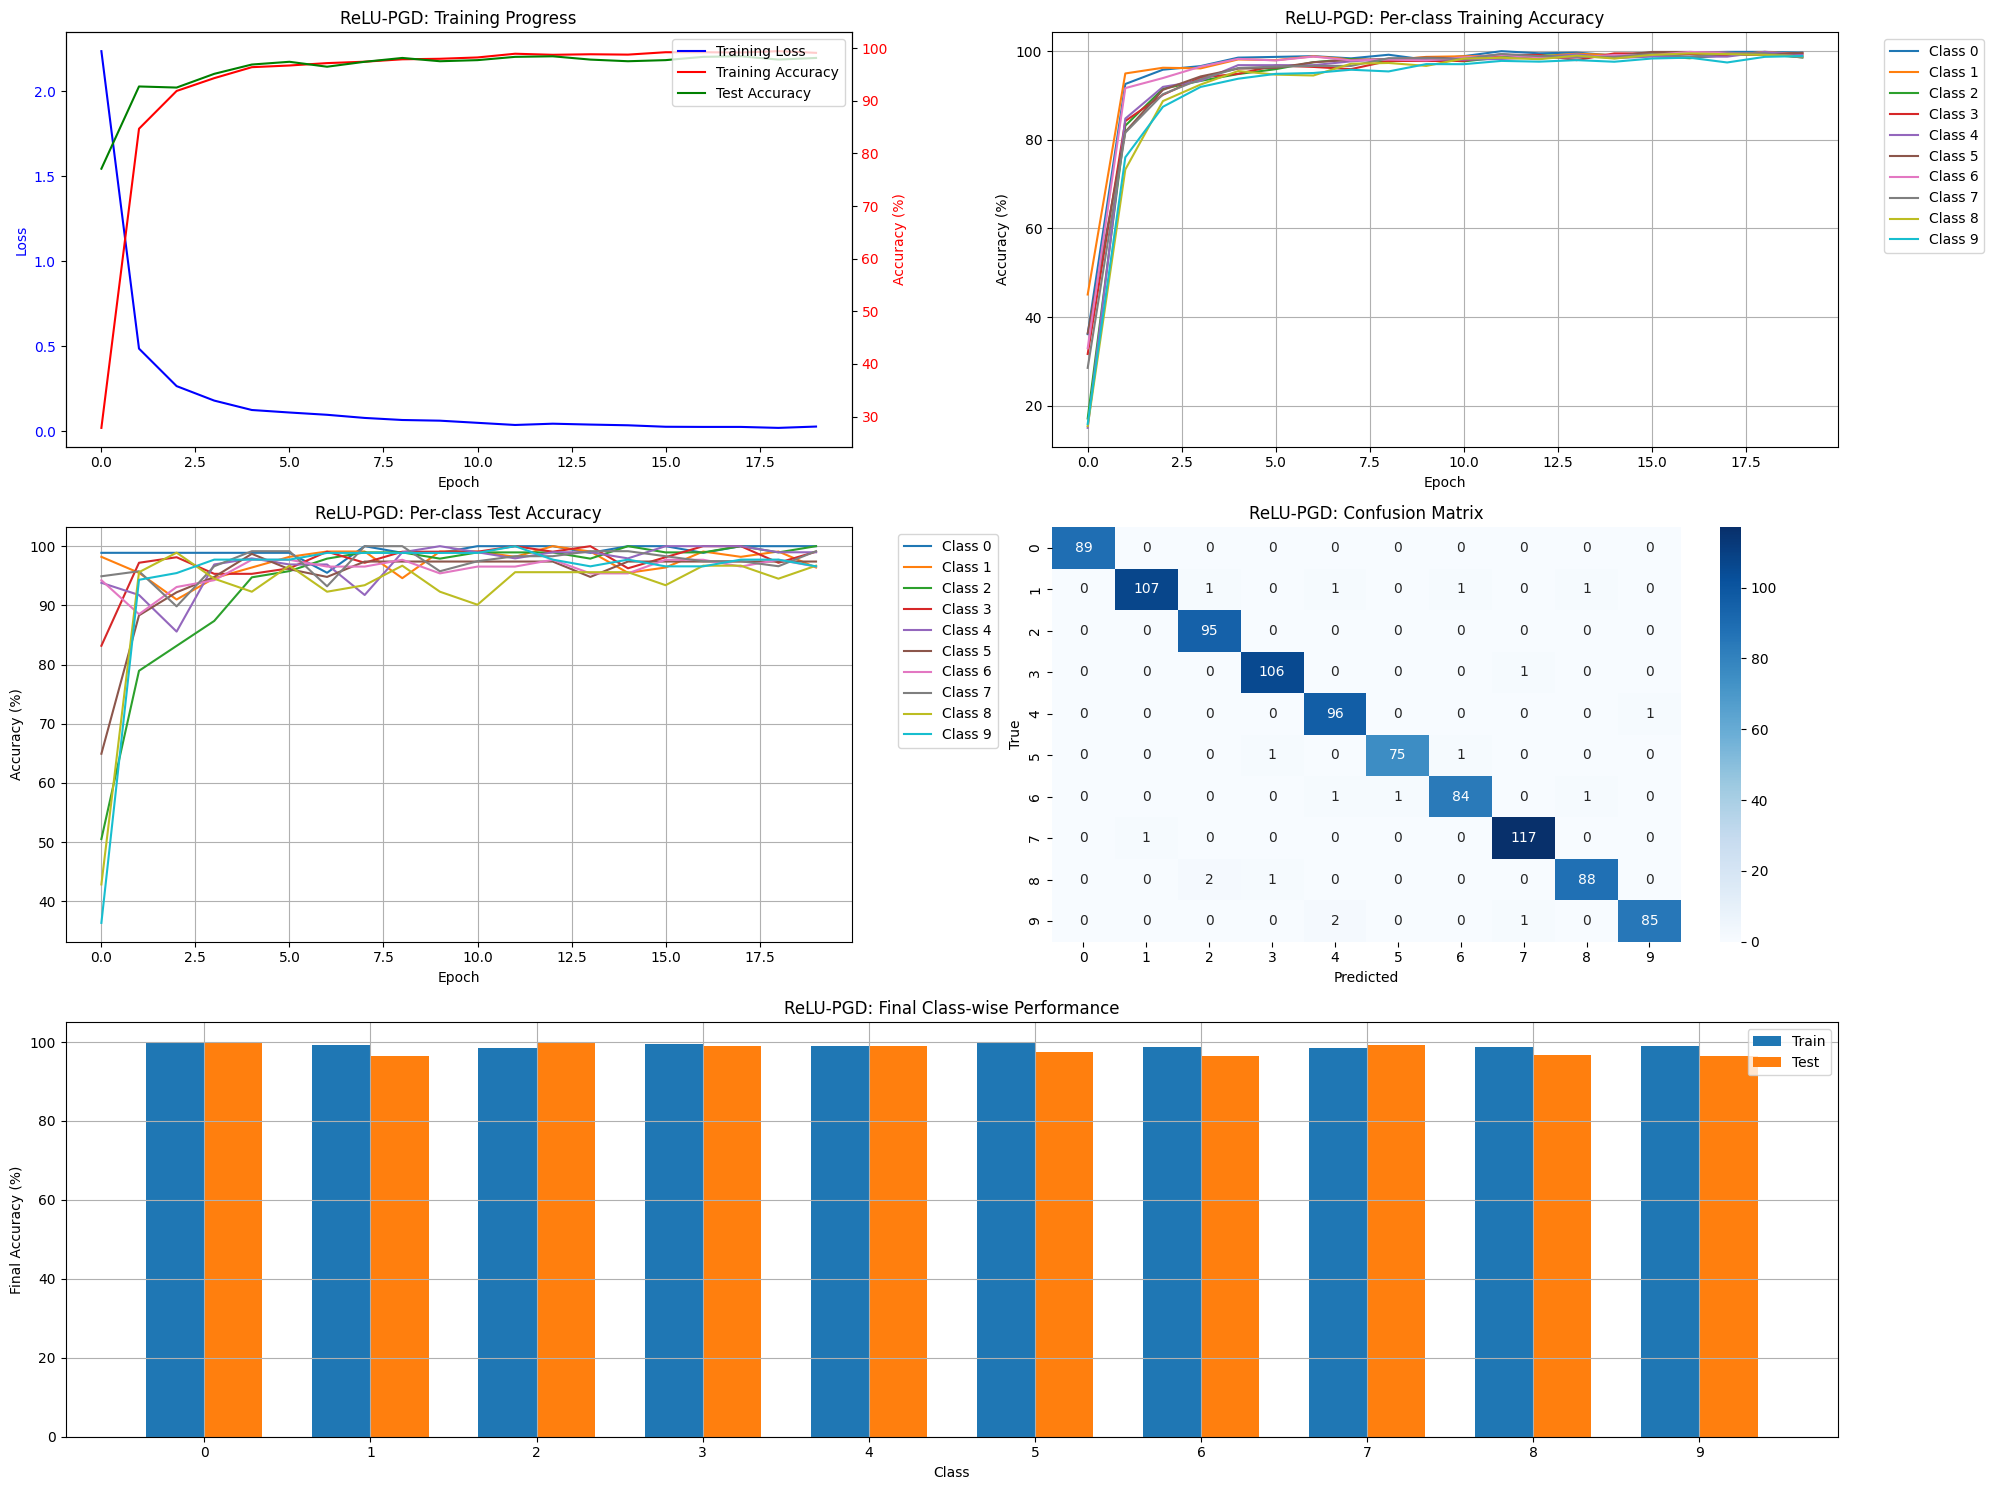

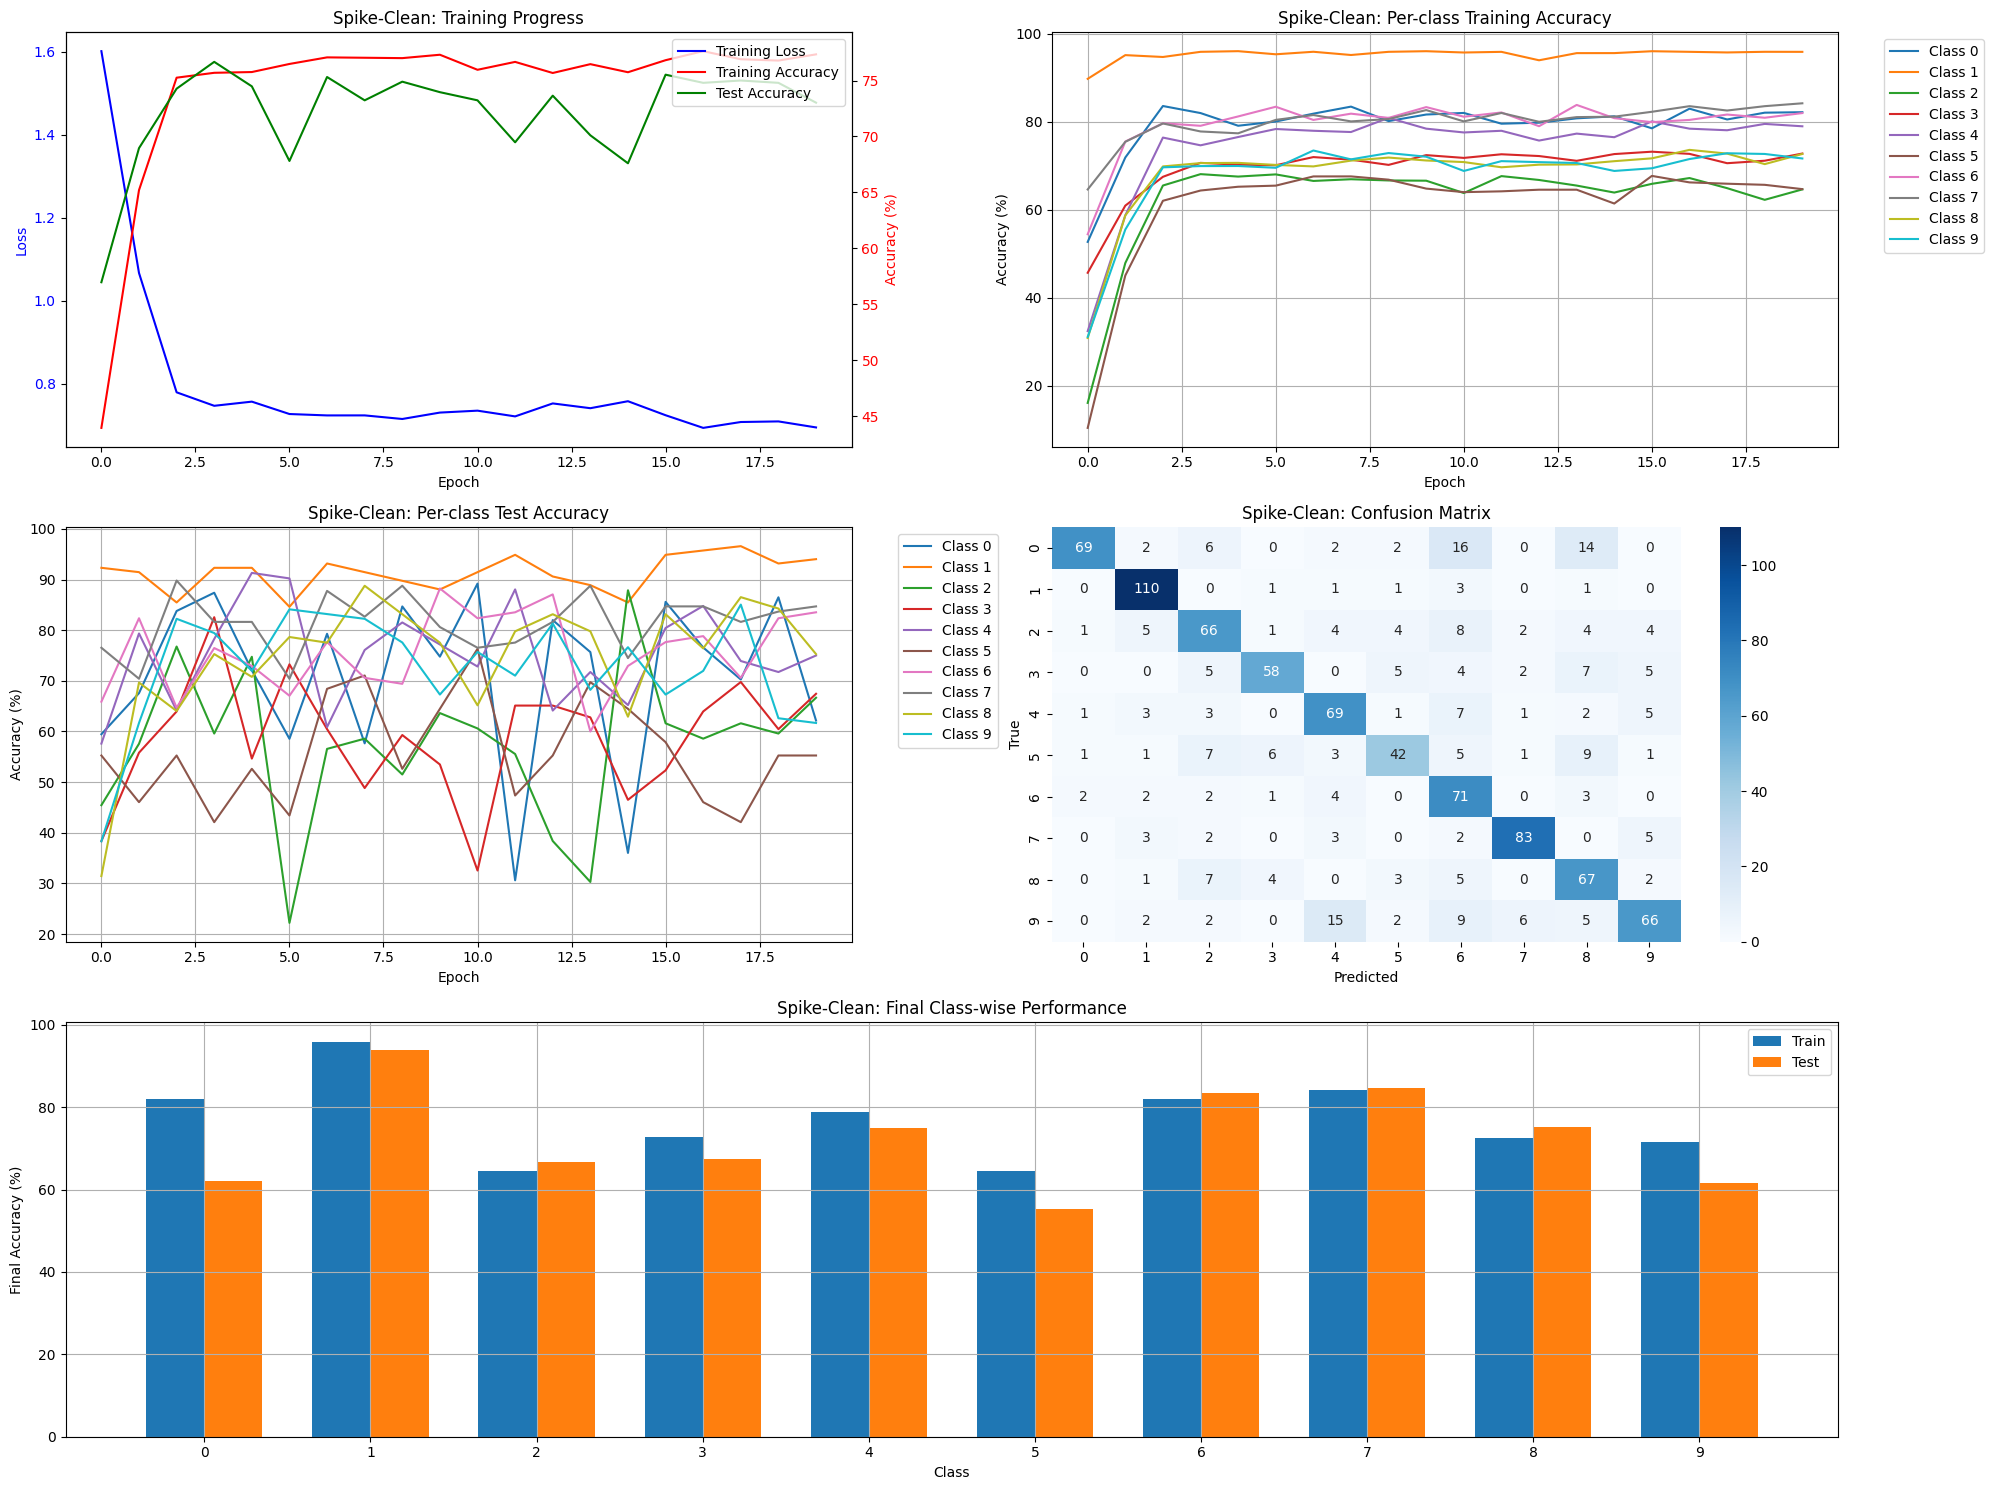

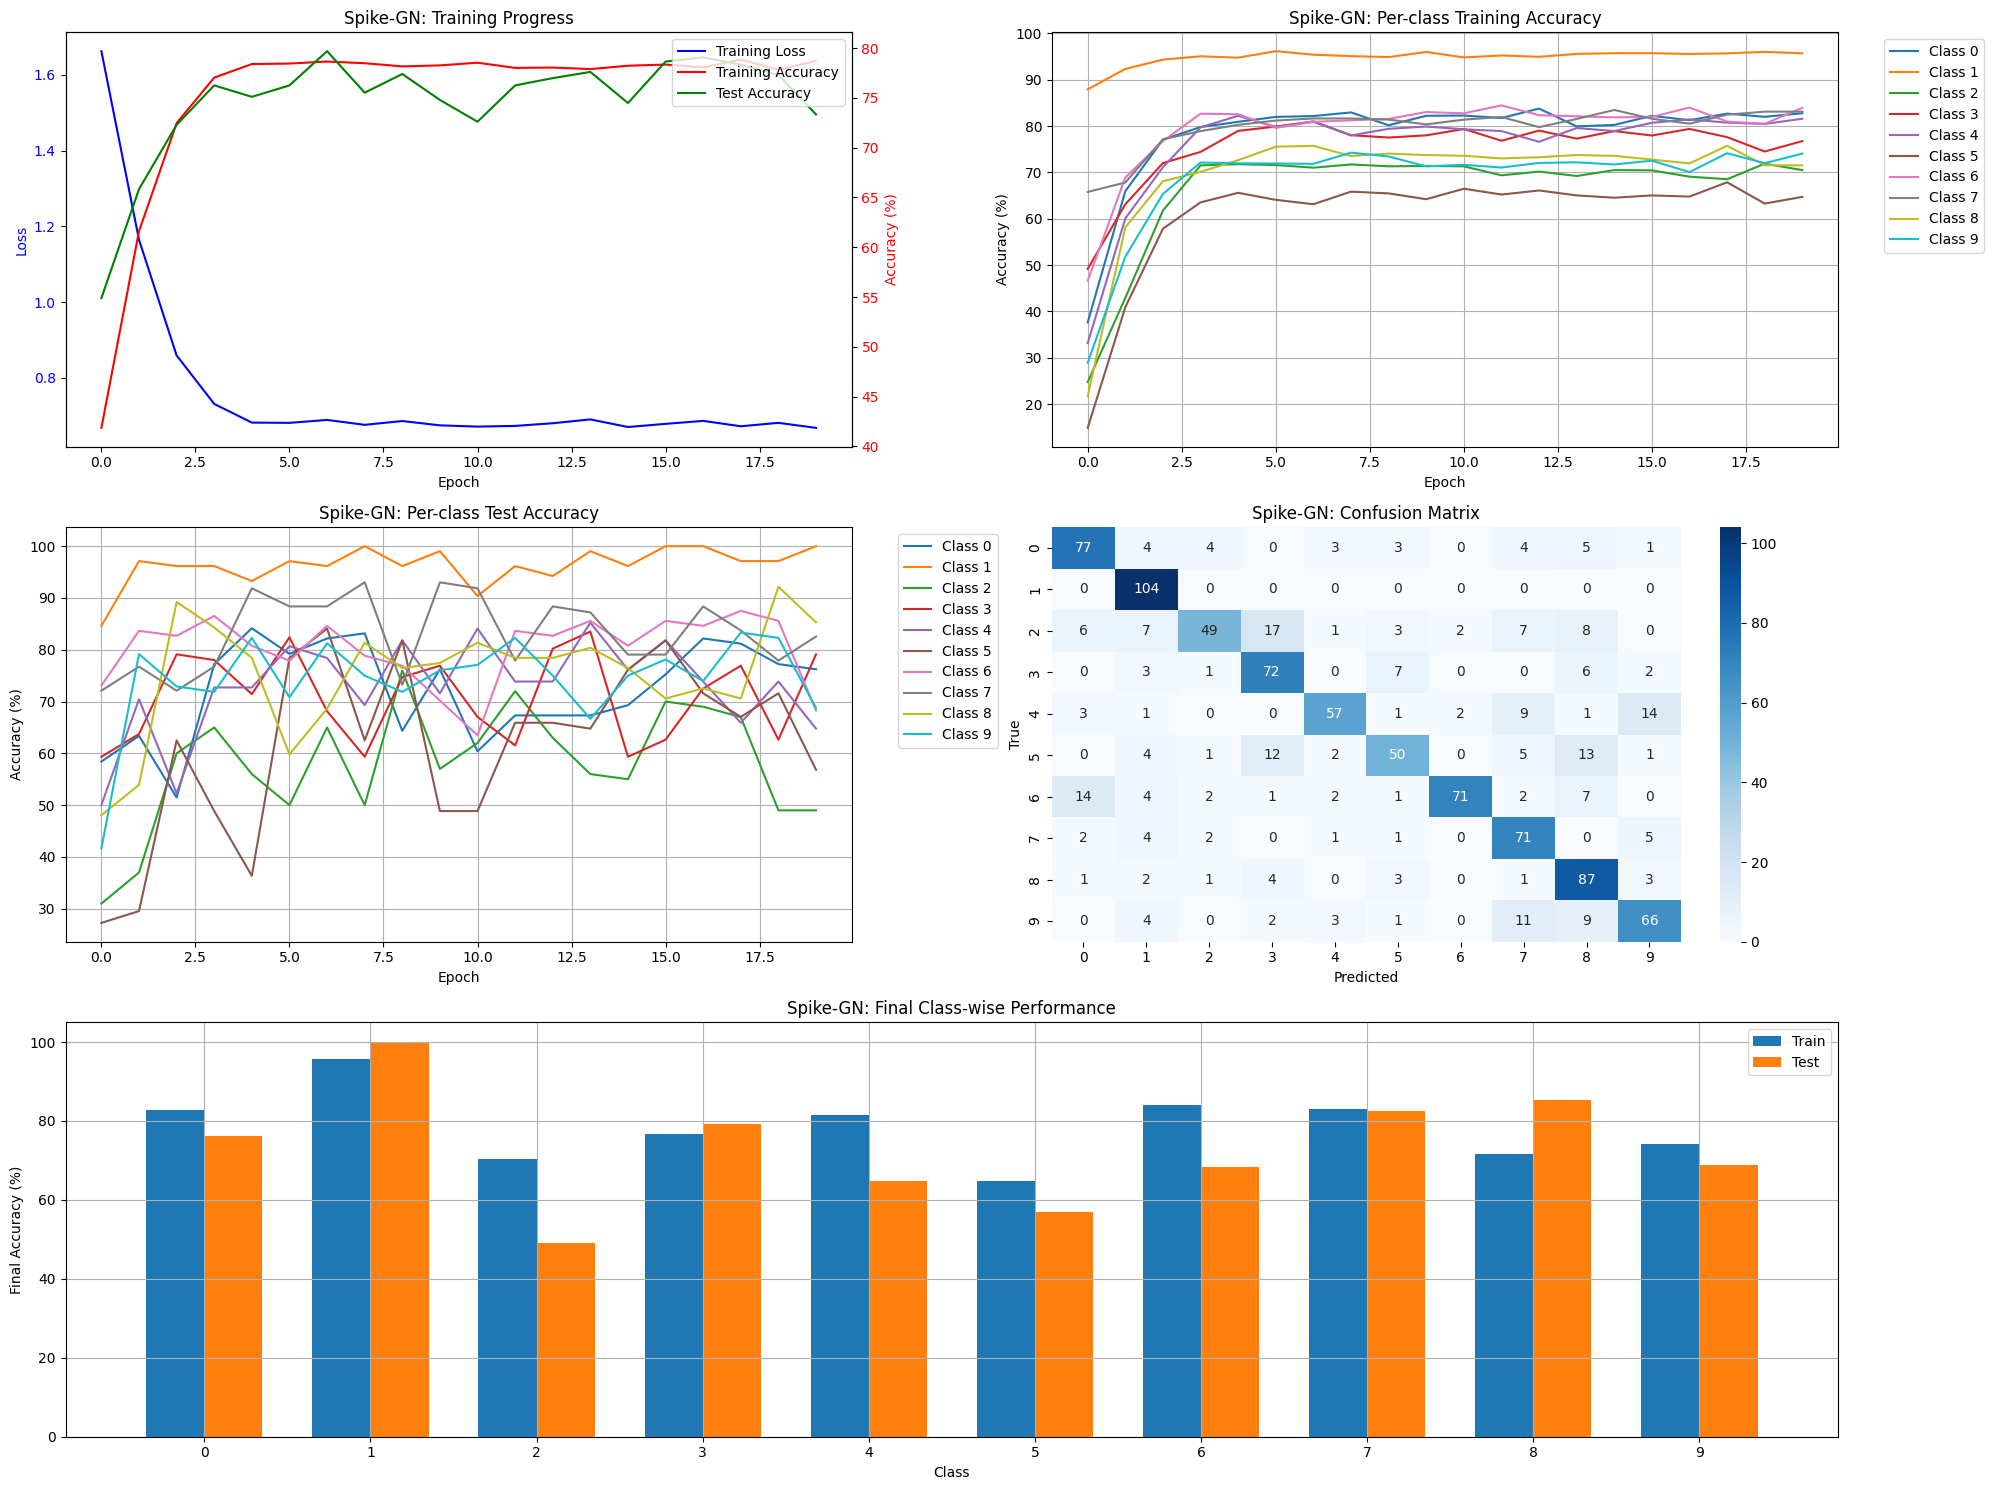

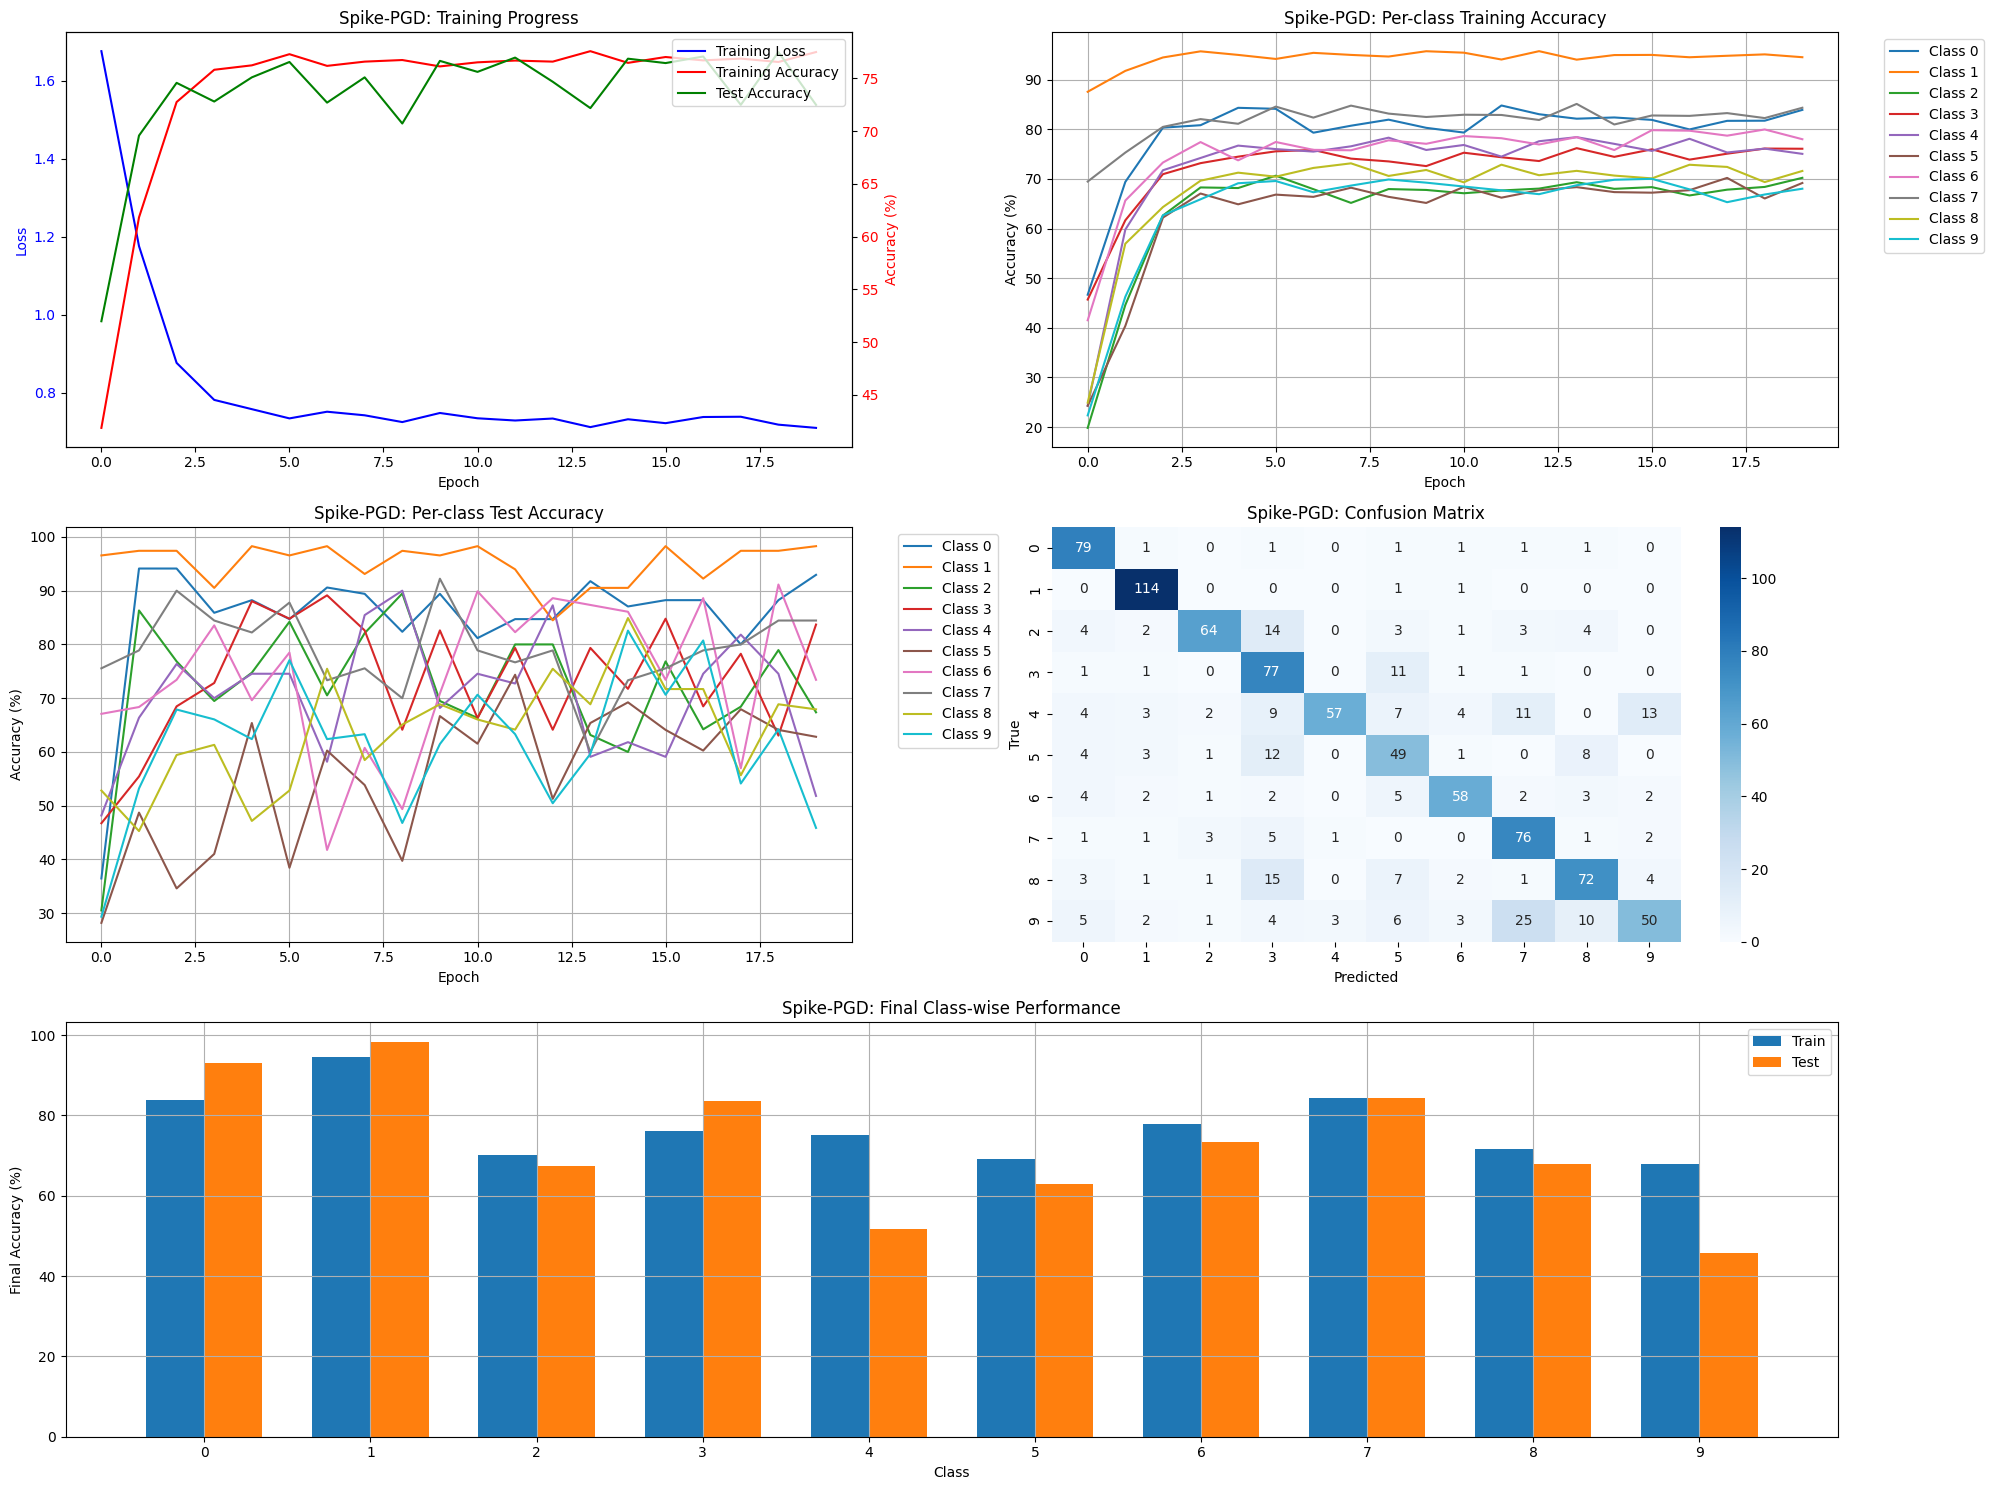

In [6]:
def plot_detailed_metrics(training_results, config_name):
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Training Loss and Accuracy
    ax1 = plt.subplot(3, 2, 1)
    ax1.plot(training_results[config_name]['train_losses'], 'b-', label='Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    
    ax2 = ax1.twinx()
    ax2.plot(training_results[config_name]['train_accuracies'], 'r-', label='Training Accuracy')
    ax2.plot(training_results[config_name]['test_accuracies'], 'g-', label='Test Accuracy')
    ax2.set_ylabel('Accuracy (%)', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    plt.title(f'{config_name}: Training Progress')
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    # 2. Per-class Training Accuracy
    ax3 = plt.subplot(3, 2, 2)
    train_class_acc = np.array(training_results[config_name]['train_class_accuracies'])
    for i in range(10):
        ax3.plot(train_class_acc[:, i], label=f'Class {i}')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Accuracy (%)')
    ax3.set_title(f'{config_name}: Per-class Training Accuracy')
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax3.grid(True)

    # 3. Per-class Test Accuracy
    ax4 = plt.subplot(3, 2, 3)
    test_class_acc = np.array(training_results[config_name]['test_class_accuracies'])
    for i in range(10):
        ax4.plot(test_class_acc[:, i], label=f'Class {i}')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Accuracy (%)')
    ax4.set_title(f'{config_name}: Per-class Test Accuracy')
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax4.grid(True)

    # 4. Final Confusion Matrix
    ax5 = plt.subplot(3, 2, 4)
    conf_matrix = training_results[config_name]['final_confusion_matrix']
    sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues', ax=ax5)
    ax5.set_xlabel('Predicted')
    ax5.set_ylabel('True')
    ax5.set_title(f'{config_name}: Confusion Matrix')

    # 5. Class Distribution Analysis
    ax6 = plt.subplot(3, 2, (5, 6))
    final_train_acc = train_class_acc[-1]
    final_test_acc = test_class_acc[-1]
    x = np.arange(10)
    width = 0.35
    ax6.bar(x - width/2, final_train_acc, width, label='Train')
    ax6.bar(x + width/2, final_test_acc, width, label='Test')
    ax6.set_xlabel('Class')
    ax6.set_ylabel('Final Accuracy (%)')
    ax6.set_title(f'{config_name}: Final Class-wise Performance')
    ax6.set_xticks(x)
    ax6.set_xticklabels([f'{i}' for i in range(10)])
    ax6.legend()
    ax6.grid(True)

    plt.tight_layout()
    plt.show()

# Plot detailed metrics for each configuration
for config in configs:
    plot_detailed_metrics(training_results, config['name'])

In [38]:
import reload_all
reload_all.reload()

# Import the updated test function
from notebook_helpers import test

Reloading atk...
Successfully reloaded atk
Reloading model...
Successfully reloaded model
Reloading model_test...
Successfully reloaded model_test
Reloading notebook_helpers...
Successfully reloaded notebook_helpers
Re-importing updated functions...
All modules successfully reloaded!


In [39]:
test_results = {}
for config in configs:
    model_path = training_results[config['name']]['model_path']
    print(f"\nTesting {config['name']}...")
    results = test(
        model_path=model_path,
        use_spike=config['use_spike']
    )
    test_results[config['name']] = results


Testing ReLU-Clean...
Model loaded successfully from ./weight/resnet34_spike_False_atk_none.pth
Testing model with model_type=standard (spike=False)
Detected resnet34 architecture in saved model
Using standard ResNet34 model

Testing ReLU-GN...
Model loaded successfully from ./weight/resnet34_spike_False_atk_gn.pth
Testing model with model_type=standard (spike=False)
Detected resnet34 architecture in saved model
Using standard ResNet34 model

Testing ReLU-PGD...
Model loaded successfully from ./weight/resnet34_spike_False_atk_pgd.pth
Testing model with model_type=standard (spike=False)
Detected resnet34 architecture in saved model
Using standard ResNet34 model

Testing Spike-Clean...
Model loaded successfully from ./weight/stateless_resnet_spike_True_atk_none.pth
Testing model with model_type=stateless_resnet (spike=True)
Detected resnet18 architecture in saved model
Using StatelessResNet18 model with T=4
Using random search in iteration 0 (no gradients)
Using random search in iterati

/home/joel/code/SEP740-Deep-Learning/atk.py:158: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)


Using random search in iteration 2 (no gradients)
Using random search in iteration 3 (no gradients)
Using random search in iteration 4 (no gradients)
Using random search in iteration 5 (no gradients)
Using random search in iteration 6 (no gradients)
Using random search in iteration 7 (no gradients)
Using random search in iteration 8 (no gradients)
Using random search in iteration 9 (no gradients)
Using random search in iteration 0 (no gradients)
Using random search in iteration 1 (no gradients)
Using random search in iteration 2 (no gradients)
Using random search in iteration 3 (no gradients)
Using random search in iteration 4 (no gradients)
Using random search in iteration 5 (no gradients)
Using random search in iteration 6 (no gradients)
Using random search in iteration 7 (no gradients)
Using random search in iteration 8 (no gradients)
Using random search in iteration 9 (no gradients)
Using random search in iteration 0 (no gradients)
Using random search in iteration 1 (no gradients)


/home/joel/code/SEP740-Deep-Learning/atk.py:158: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)


Using random search in iteration 2 (no gradients)
Using random search in iteration 3 (no gradients)
Using random search in iteration 4 (no gradients)
Using random search in iteration 5 (no gradients)
Using random search in iteration 6 (no gradients)
Using random search in iteration 7 (no gradients)
Using random search in iteration 8 (no gradients)
Using random search in iteration 9 (no gradients)
Using random search in iteration 0 (no gradients)
Using random search in iteration 1 (no gradients)
Using random search in iteration 2 (no gradients)
Using random search in iteration 3 (no gradients)
Using random search in iteration 4 (no gradients)
Using random search in iteration 5 (no gradients)
Using random search in iteration 6 (no gradients)
Using random search in iteration 7 (no gradients)
Using random search in iteration 8 (no gradients)
Using random search in iteration 9 (no gradients)
Using random search in iteration 0 (no gradients)
Using random search in iteration 1 (no gradients)


/home/joel/code/SEP740-Deep-Learning/atk.py:158: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)


Using random search in iteration 2 (no gradients)
Using random search in iteration 3 (no gradients)
Using random search in iteration 4 (no gradients)
Using random search in iteration 5 (no gradients)
Using random search in iteration 6 (no gradients)
Using random search in iteration 7 (no gradients)
Using random search in iteration 8 (no gradients)
Using random search in iteration 9 (no gradients)
Using random search in iteration 0 (no gradients)
Using random search in iteration 1 (no gradients)
Using random search in iteration 2 (no gradients)
Using random search in iteration 3 (no gradients)
Using random search in iteration 4 (no gradients)
Using random search in iteration 5 (no gradients)
Using random search in iteration 6 (no gradients)
Using random search in iteration 7 (no gradients)
Using random search in iteration 8 (no gradients)
Using random search in iteration 9 (no gradients)
Using random search in iteration 0 (no gradients)
Using random search in iteration 1 (no gradients)


/home/joel/code/SEP740-Deep-Learning/atk.py:158: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)


Using random search in iteration 2 (no gradients)
Using random search in iteration 3 (no gradients)
Using random search in iteration 4 (no gradients)
Using random search in iteration 5 (no gradients)
Using random search in iteration 6 (no gradients)
Using random search in iteration 7 (no gradients)
Using random search in iteration 8 (no gradients)
Using random search in iteration 9 (no gradients)
Using random search in iteration 0 (no gradients)
Using random search in iteration 1 (no gradients)
Using random search in iteration 2 (no gradients)
Using random search in iteration 3 (no gradients)
Using random search in iteration 4 (no gradients)
Using random search in iteration 5 (no gradients)
Using random search in iteration 6 (no gradients)
Using random search in iteration 7 (no gradients)
Using random search in iteration 8 (no gradients)
Using random search in iteration 9 (no gradients)
Using random search in iteration 0 (no gradients)
Using random search in iteration 1 (no gradients)


/home/joel/code/SEP740-Deep-Learning/atk.py:158: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)


Using random search in iteration 1 (no gradients)
Using random search in iteration 2 (no gradients)
Using random search in iteration 3 (no gradients)
Using random search in iteration 4 (no gradients)
Using random search in iteration 5 (no gradients)
Using random search in iteration 6 (no gradients)
Using random search in iteration 7 (no gradients)
Using random search in iteration 8 (no gradients)
Using random search in iteration 9 (no gradients)
Using random search in iteration 0 (no gradients)
Using random search in iteration 1 (no gradients)
Using random search in iteration 2 (no gradients)
Using random search in iteration 3 (no gradients)
Using random search in iteration 4 (no gradients)
Using random search in iteration 5 (no gradients)
Using random search in iteration 6 (no gradients)
Using random search in iteration 7 (no gradients)
Using random search in iteration 8 (no gradients)
Using random search in iteration 9 (no gradients)
Using random search in iteration 0 (no gradients)


/home/joel/code/SEP740-Deep-Learning/atk.py:158: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)


Using random search in iteration 1 (no gradients)
Using random search in iteration 2 (no gradients)
Using random search in iteration 3 (no gradients)
Using random search in iteration 4 (no gradients)
Using random search in iteration 5 (no gradients)
Using random search in iteration 6 (no gradients)
Using random search in iteration 7 (no gradients)
Using random search in iteration 8 (no gradients)
Using random search in iteration 9 (no gradients)
Using random search in iteration 0 (no gradients)
Using random search in iteration 1 (no gradients)
Using random search in iteration 2 (no gradients)
Using random search in iteration 3 (no gradients)
Using random search in iteration 4 (no gradients)
Using random search in iteration 5 (no gradients)
Using random search in iteration 6 (no gradients)
Using random search in iteration 7 (no gradients)
Using random search in iteration 8 (no gradients)
Using random search in iteration 9 (no gradients)
Using random search in iteration 0 (no gradients)


/home/joel/code/SEP740-Deep-Learning/atk.py:158: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)


Using random search in iteration 1 (no gradients)
Using random search in iteration 2 (no gradients)
Using random search in iteration 3 (no gradients)
Using random search in iteration 4 (no gradients)
Using random search in iteration 5 (no gradients)
Using random search in iteration 6 (no gradients)
Using random search in iteration 7 (no gradients)
Using random search in iteration 8 (no gradients)
Using random search in iteration 9 (no gradients)
Using random search in iteration 0 (no gradients)
Using random search in iteration 1 (no gradients)
Using random search in iteration 2 (no gradients)
Using random search in iteration 3 (no gradients)
Using random search in iteration 4 (no gradients)
Using random search in iteration 5 (no gradients)
Using random search in iteration 6 (no gradients)
Using random search in iteration 7 (no gradients)
Using random search in iteration 8 (no gradients)
Using random search in iteration 9 (no gradients)
Using random search in iteration 0 (no gradients)


/home/joel/code/SEP740-Deep-Learning/atk.py:158: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)


Using random search in iteration 1 (no gradients)
Using random search in iteration 2 (no gradients)
Using random search in iteration 3 (no gradients)
Using random search in iteration 4 (no gradients)
Using random search in iteration 5 (no gradients)
Using random search in iteration 6 (no gradients)
Using random search in iteration 7 (no gradients)
Using random search in iteration 8 (no gradients)
Using random search in iteration 9 (no gradients)
Using random search in iteration 0 (no gradients)
Using random search in iteration 1 (no gradients)
Using random search in iteration 2 (no gradients)
Using random search in iteration 3 (no gradients)
Using random search in iteration 4 (no gradients)
Using random search in iteration 5 (no gradients)
Using random search in iteration 6 (no gradients)
Using random search in iteration 7 (no gradients)
Using random search in iteration 8 (no gradients)
Using random search in iteration 9 (no gradients)
Using random search in iteration 0 (no gradients)


/home/joel/code/SEP740-Deep-Learning/atk.py:158: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)


Using random search in iteration 2 (no gradients)
Using random search in iteration 3 (no gradients)
Using random search in iteration 4 (no gradients)
Using random search in iteration 5 (no gradients)
Using random search in iteration 6 (no gradients)
Using random search in iteration 7 (no gradients)
Using random search in iteration 8 (no gradients)
Using random search in iteration 9 (no gradients)
Using random search in iteration 0 (no gradients)
Using random search in iteration 1 (no gradients)
Using random search in iteration 2 (no gradients)
Using random search in iteration 3 (no gradients)
Using random search in iteration 4 (no gradients)
Using random search in iteration 5 (no gradients)
Using random search in iteration 6 (no gradients)
Using random search in iteration 7 (no gradients)
Using random search in iteration 8 (no gradients)
Using random search in iteration 9 (no gradients)
Using random search in iteration 0 (no gradients)
Using random search in iteration 1 (no gradients)


In [40]:
# Attack Performance Comparison

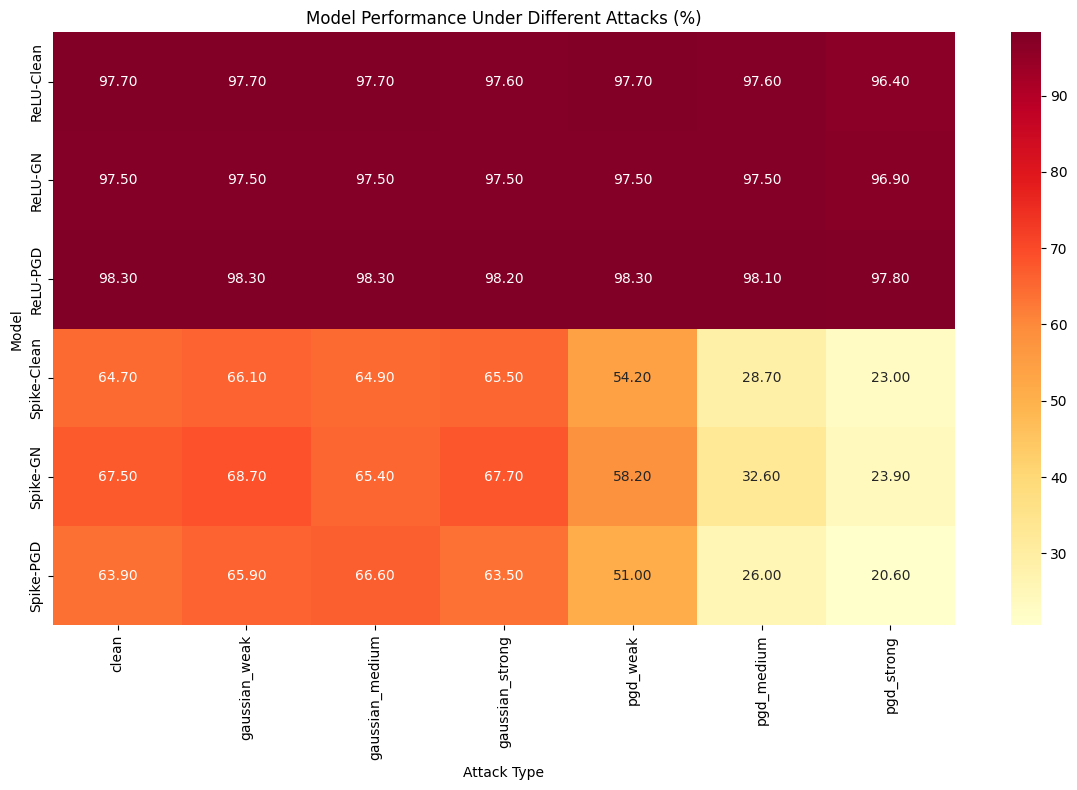

In [41]:
# Create comparison heatmap
model_names = list(test_results.keys())
attack_names = list(ATTACK_CONFIGS.keys())
comparison_matrix = np.zeros((len(model_names), len(attack_names)))

for i, model_name in enumerate(model_names):
    for j, attack_name in enumerate(attack_names):
        comparison_matrix[i, j] = test_results[model_name][attack_name]['test_acc']

plt.figure(figsize=(12, 8))
sns.heatmap(comparison_matrix, 
            annot=True, 
            fmt='.2f',
            xticklabels=attack_names,
            yticklabels=model_names,
            cmap='YlOrRd')
plt.xlabel('Attack Type')
plt.ylabel('Model')
plt.title('Model Performance Under Different Attacks (%)')
plt.tight_layout()
plt.show()

In [42]:
# Per-Class Analysis

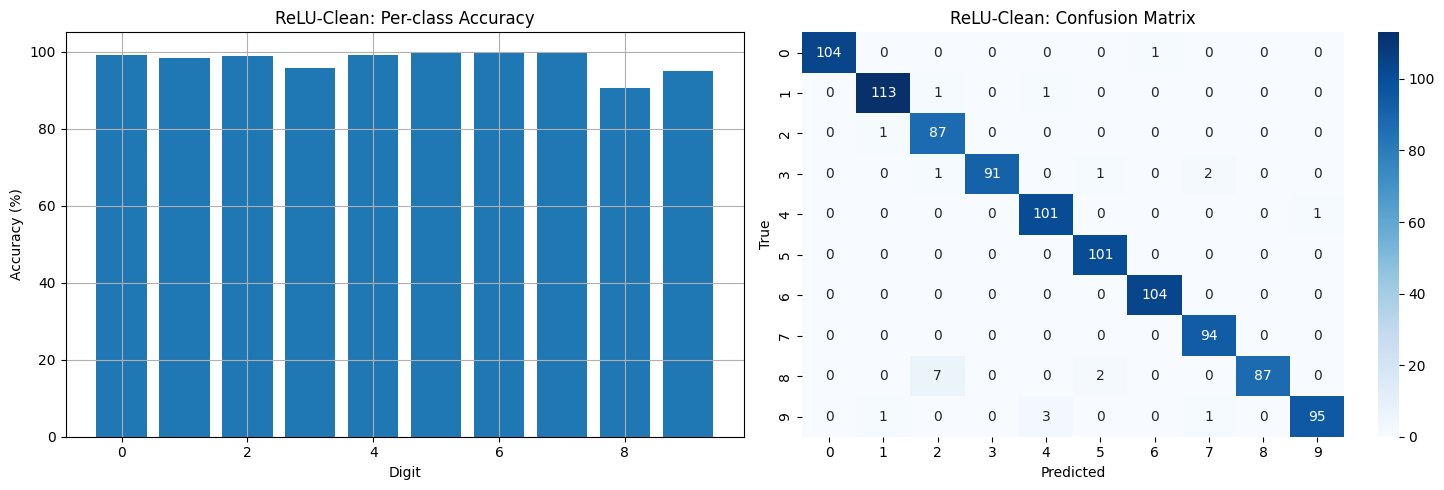

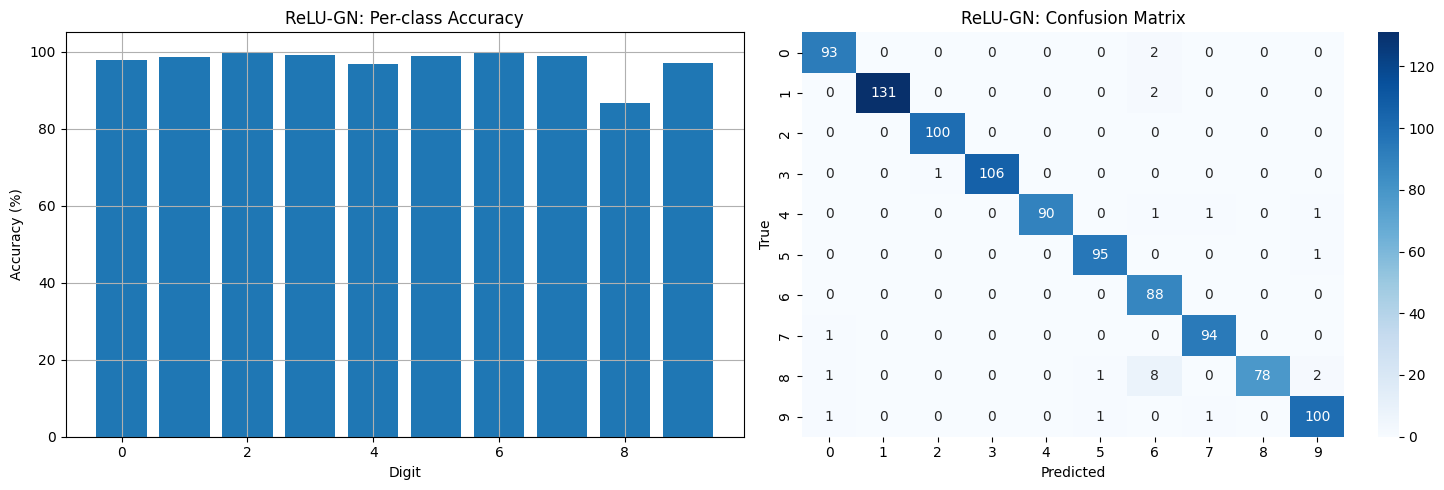

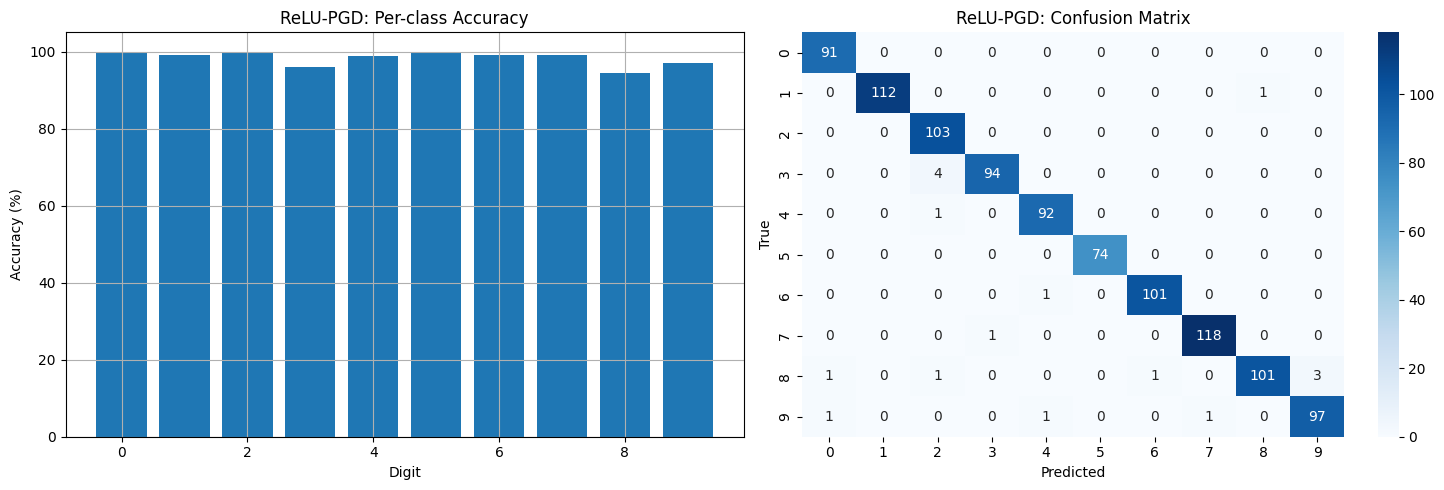

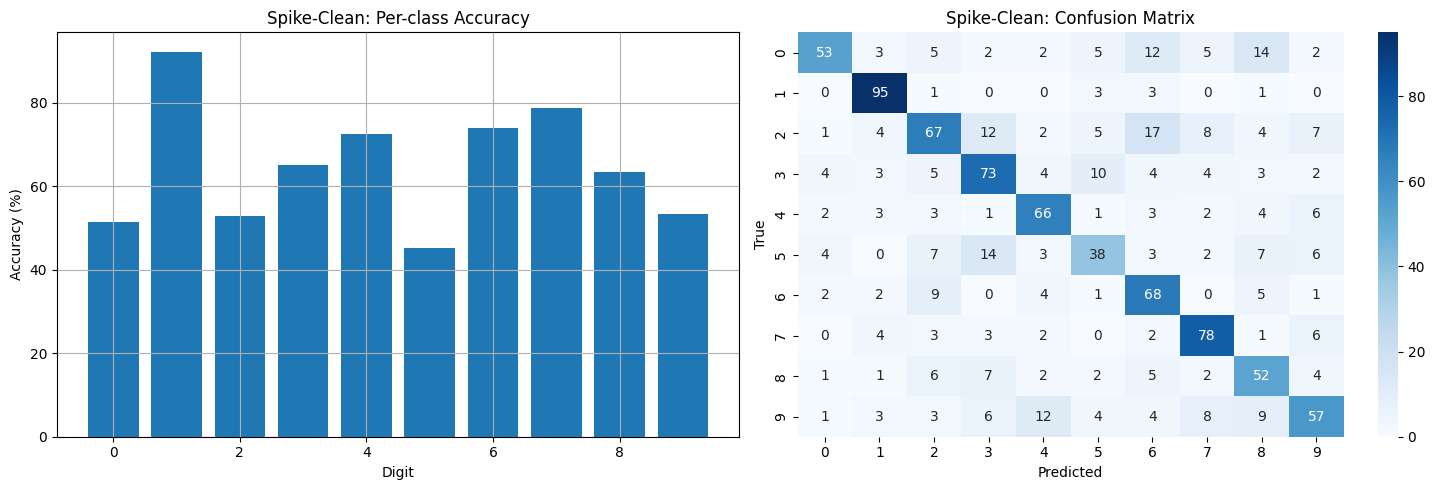

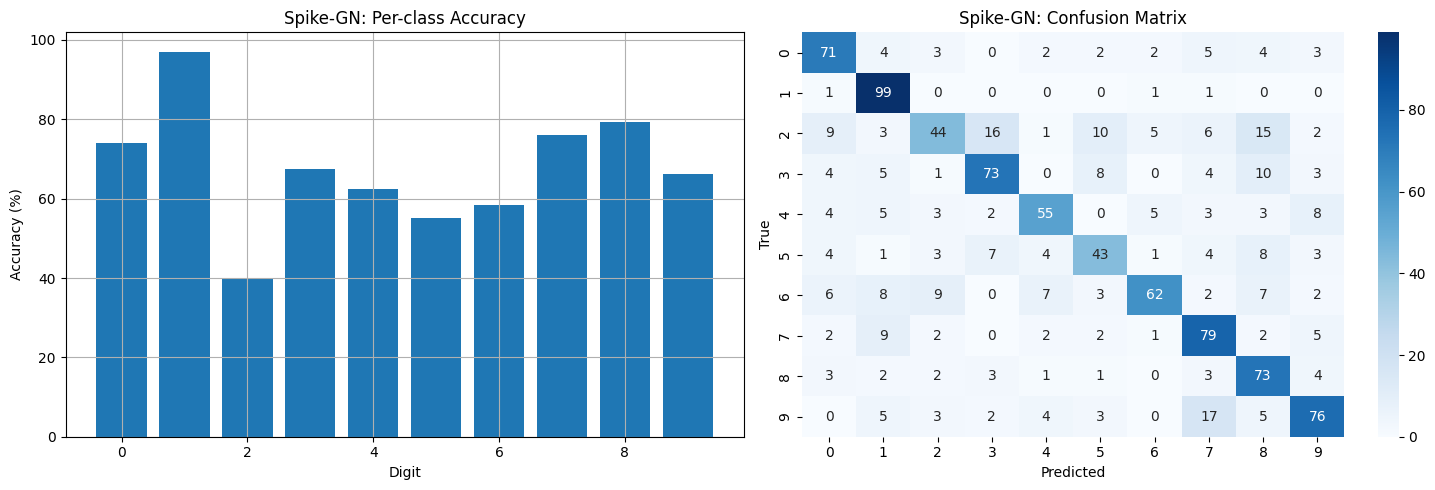

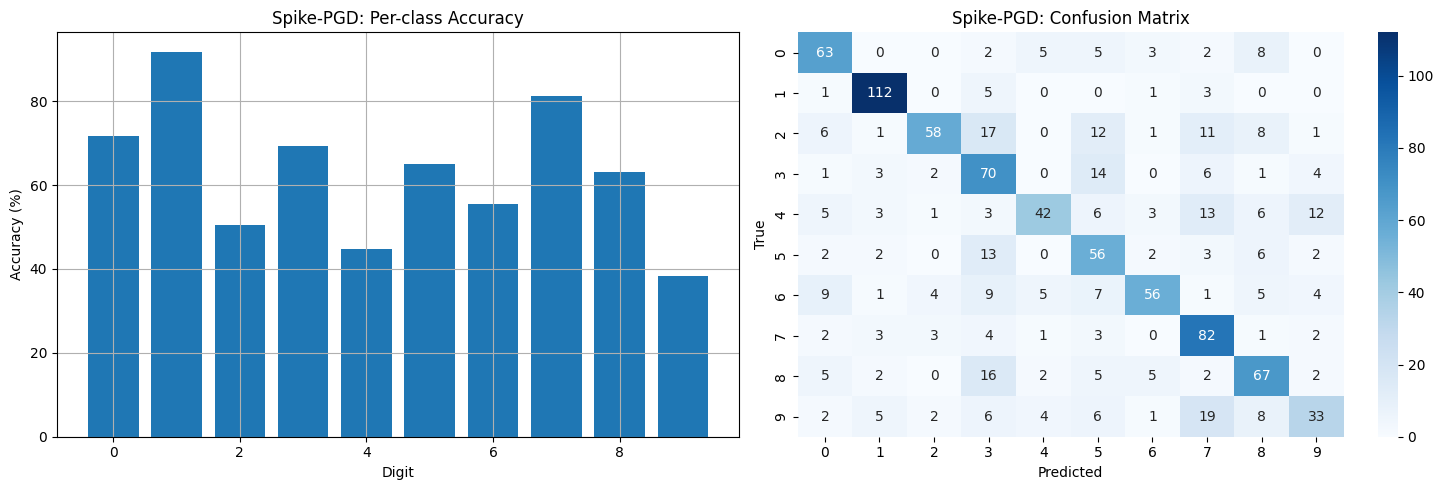

In [43]:
# Per-class analysis for each model
for config in configs:
    model_name = config['name']
    plt.figure(figsize=(15, 5))
    
    # Per-class accuracy bar plot
    plt.subplot(1, 2, 1)
    class_acc = test_results[model_name]['clean']['class_accuracies']
    plt.bar(range(10), class_acc)
    plt.xlabel('Digit')
    plt.ylabel('Accuracy (%)')
    plt.title(f'{model_name}: Per-class Accuracy')
    plt.grid(True)
    
    # Confusion matrix
    plt.subplot(1, 2, 2)
    conf_matrix = test_results[model_name]['clean']['confusion_matrix']
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{model_name}: Confusion Matrix')
    
    plt.tight_layout()
    plt.show()

In [44]:
# Attack Effectiveness Comparison

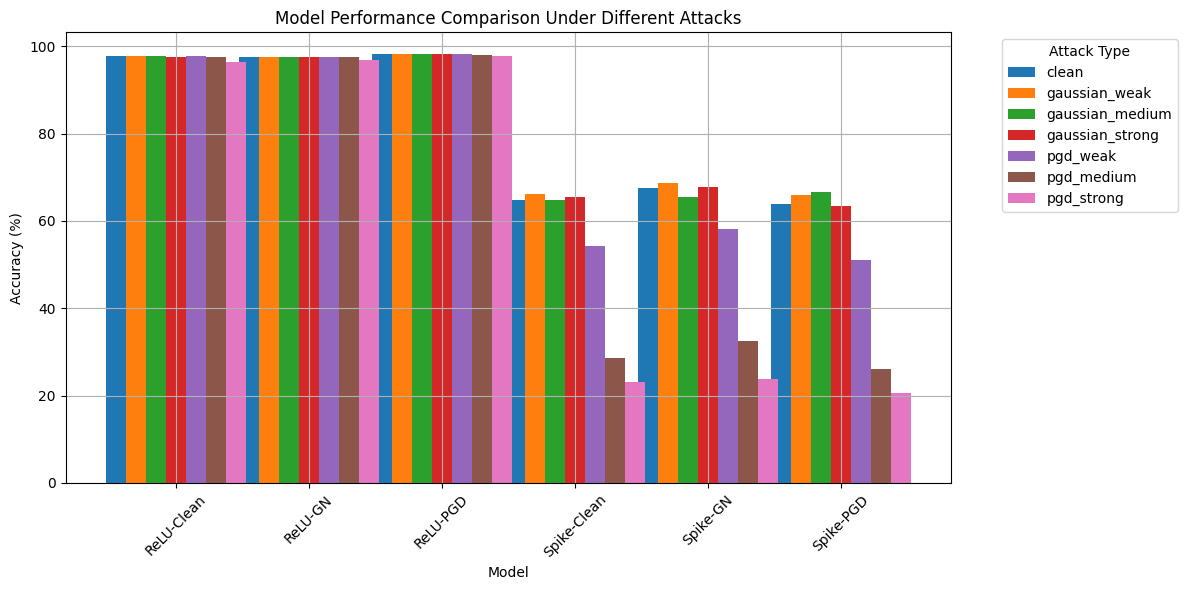

In [45]:
# Attack effectiveness bar plot
plt.figure(figsize=(12, 6))
x = np.arange(len(model_names))
width = 0.15
multiplier = 0

for attack_name in attack_names:
    attack_accuracies = [test_results[model_name][attack_name]['test_acc'] 
                        for model_name in model_names]
    offset = width * multiplier
    plt.bar(x + offset, attack_accuracies, width, label=attack_name)
    multiplier += 1

plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.title('Model Performance Comparison Under Different Attacks')
plt.xticks(x + width * (len(attack_names)-1)/2, model_names, rotation=45)
plt.legend(title='Attack Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [46]:
# Summary Statistics

In [47]:
print("\nSummary Statistics:")
print("-" * 80)
print(f"{'Model':<15} {'Clean':>10} {'GN (weak)':>10} {'GN (strong)':>10} {'PGD (weak)':>10} {'PGD (strong)':>10}")
print("-" * 80)

for model_name in model_names:
    stats = [
        test_results[model_name]['clean']['test_acc'],
        test_results[model_name]['gaussian_weak']['test_acc'],
        test_results[model_name]['gaussian_strong']['test_acc'],
        test_results[model_name]['pgd_weak']['test_acc'],
        test_results[model_name]['pgd_strong']['test_acc']
    ]
    print(f"{model_name:<15}", end="")
    for stat in stats:
        print(f"{stat:>10.2f}", end="")
    print()


Summary Statistics:
--------------------------------------------------------------------------------
Model                Clean  GN (weak) GN (strong) PGD (weak) PGD (strong)
--------------------------------------------------------------------------------
ReLU-Clean          97.70     97.70     97.60     97.70     96.40
ReLU-GN             97.50     97.50     97.50     97.50     96.90
ReLU-PGD            98.30     98.30     98.20     98.30     97.80
Spike-Clean         64.70     66.10     65.50     54.20     23.00
Spike-GN            67.50     68.70     67.70     58.20     23.90
Spike-PGD           63.90     65.90     63.50     51.00     20.60
